In [1]:
import sys

import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderConfig, VisionEncoderDecoderModel

sys.path.append("../")
from src import DocProcessor, DocDataset, Params, denormalize_batch, show_tensor_images

In [2]:
torch.set_printoptions(edgeitems=7, threshold=50, sci_mode=False)

In [3]:
config_path = "../configs/train_config.json"

In [4]:
config = Params(config_path)

In [5]:
donut_model_config = VisionEncoderDecoderConfig.from_pretrained(config.MODEL.BASE_MODEL_NAME)
donut_model_config.encoder.image_size = config.DATA.IMAGE_SIZE
donut_model_config.decoder.max_length = config.DATA.MAX_LENGTH
donut_model = VisionEncoderDecoderModel.from_pretrained(config.MODEL.BASE_MODEL_NAME, config=donut_model_config)

In [6]:
doc_processor = DocProcessor.from_pretrained_with_model(donut_model, config.MODEL.BASE_MODEL_NAME)
doc_processor.image_processor.size = config.DATA.IMAGE_SIZE[::-1]
doc_processor.image_processor.do_align_long_axis = config.DATA.DO_ALIGN_LONG_AXIS

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [7]:
donut_model.config.pad_token_id = doc_processor.tokenizer.pad_token_id
donut_model.config.decoder_start_token_id = doc_processor.tokenizer.convert_tokens_to_ids(config.DATA.TASK_START_TOKEN)

# Look at Prepared Data

In [8]:
image_mean = doc_processor.image_processor.image_mean
image_std = doc_processor.image_processor.image_std

In [9]:
dash_line = "-".join(" " for _ in range(100))

In [10]:
def visualize_data(data):
    pixel_values, labels, target_sequence = data
    image = denormalize_batch(pixel_values.unsqueeze(0), image_mean, image_std)
    decoded_labels  = labels.clone()
    decoded_labels[decoded_labels == config.DATA.IGNORE_ID] = doc_processor.tokenizer.pad_token_id
    decoded_labels = doc_processor.tokenizer.decode(decoded_labels)
    
    print(dash_line)
    print(f"IMAGE:\n")
    show_tensor_images(image, num=1)
    print(dash_line)
    print(f"LABELS:\n{labels}")
    print(dash_line)
    print(f"DECODED LABELS:\n{decoded_labels}")
    print(dash_line)
    print(f"TARGET_SEQUENCE:\n{target_sequence}")
    print(dash_line)

In [11]:
train_dataset = DocDataset(
    config.DATA.DATASET_NAME,
    doc_processor,
    config.DATA.MAX_LENGTH,
    split="train",
    ignore_id=config.DATA.IGNORE_ID,
    task_start_token=config.DATA.TASK_START_TOKEN,
    prompt_end_token=config.DATA.PROMPT_END_TOKEN,
    sort_json_key=config.DATA.SORT_JSON_KEY,
)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 1
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
IMAGE:



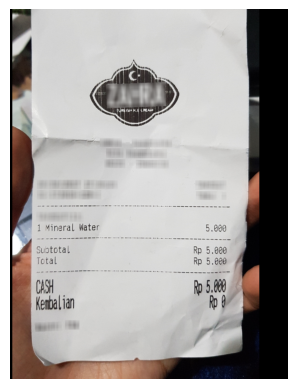

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57526, 57527, 57529, 20017, 53692, 57530, 57555,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
TARGET_SEQUENCE:
<s_total><s_total_price>5.000</s_total_price><s_changeprice>0</s_changeprice><s_cashprice>5.000</s_cashprice></s_total><s_sub_total><s_subtotal_price>5.000</s_subtotal_price></s_sub_total><s_menu><s_price>5.000</s_price><s_nm>Mineral Water</s_nm><s_cnt>1</s_cnt></s_menu>
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

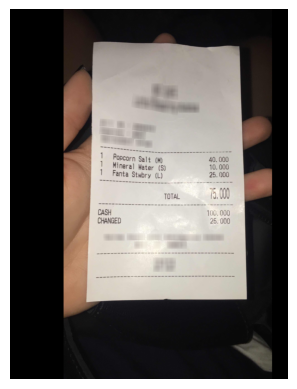

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57526, 57527, 57529, 42812, 53692, 57530, 57555,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
TARGET_SEQUENCE:
<s_total><s_total_price>75.000</s_total_price><s_changeprice>25.000</s_changeprice><s_cashprice>100.000</s_cashprice></s_total><s_menu><s_price>40.000</s_price><s_nm>Popcorn Salt (M)</s_nm><s_cnt>1</s_cnt><sep/><s_price>10.000</s_price><s_nm>Mineral Water (S)</s_nm><s_cnt>1</s_cnt><sep/><s_price>25.000</s_price><s_nm>Fanta Stwbry (L)</s_nm><s_cnt>1</s_cnt></s_menu>
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

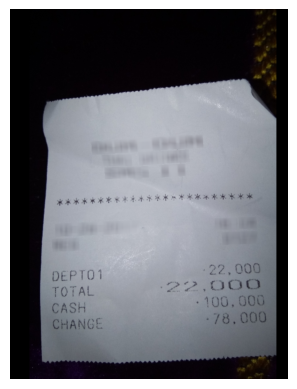

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57526, 57527, 57529,  3822, 52066, 57530, 57555,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
TARGET_SEQUENCE:
<s_total><s_total_price>22,000</s_total_price><s_changeprice>78,000</s_changeprice><s_cashprice>100,000</s_cashprice></s_total><s_menu><s_price>22,000</s_price><s_nm>DEPT01</s_nm></s_menu>
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

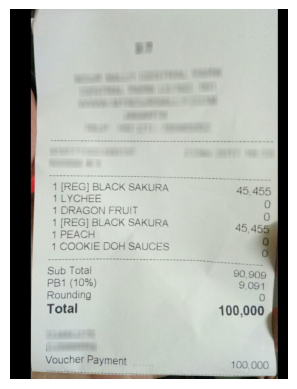

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57526, 57527, 57529, 52285, 35815, 56239, 57530,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
TARGET_SEQUENCE:
<s_total><s_total_price>100,000</s_total_price><s_total_etc>100,000</s_total_etc></s_total><s_sub_total><s_tax_price>9,091</s_tax_price><s_subtotal_price>90,909</s_subtotal_price><s_etc>0</s_etc></s_sub_total><s_menu><s_sub_price>0 0</s_sub_price><s_sub_nm>LYCHEE DRAGON FRUIT</s_sub_nm><s_sub_cnt>1 1</s_sub_cnt><s_price>45,455</s_price><s_nm>[REG] BLACK SAKURA</s_nm><s_cnt>1</s_cnt><sep/><s_sub_price>0 0</s_sub_price><s_sub_nm>PEACH COOKIE DOH SAUCES

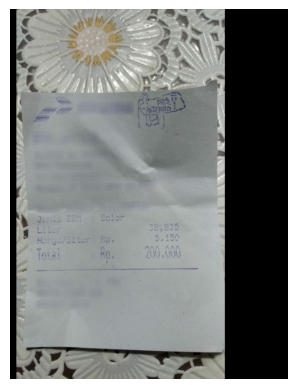

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57526, 57531, 57535, 17805, 53692, 57536, 57532,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
TARGET_SEQUENCE:
<s_sub_total><s_subtotal_price>200.000</s_subtotal_price></s_sub_total><s_menu><s_unitprice>5.150</s_unitprice><s_nm>Solar</s_nm><s_cnt>38,835</s_cnt></s_menu>
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [12]:
example_indices = np.random.randint(0, len(train_dataset), 5)

for i, index in enumerate(example_indices):
    print(dash_line)
    print("Example", i+1)
    visualize_data(train_dataset[int(index)])

# Look at Model Outputs

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=config.TRAINING.BATCH_SIZE.TRAIN, shuffle=True)

In [15]:
train_batch = next(iter(train_dataloader))

In [16]:
pixel_values, labels, target_sequence = train_batch
pixel_values, labels = pixel_values.to(device), labels.to(device)

In [17]:
donut_model = donut_model.to(device)

In [18]:
loss = donut_model(pixel_values, labels=labels).loss

OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 47.51 GiB of which 122.62 MiB is free. Process 700419 has 26.95 GiB memory in use. Including non-PyTorch memory, this process has 20.40 GiB memory in use. Of the allocated memory 19.76 GiB is allocated by PyTorch, and 146.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
loss

tensor(14.6461, device='cuda:0', grad_fn=<NllLossBackward0>)